<a href="https://colab.research.google.com/github/Hadiqapieas/Custom-Model-Architectures/blob/ResNet34/ResNet34c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# Define Residual Block
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [3]:
# Define Custom ResNet34 Model
class CustomResNet34(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(CustomResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize and Print the Model
model = CustomResNet34(ResidualBlock, [3, 4, 6, 3], num_classes=2)
print(model)

CustomResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [4]:
!unzip train_dataset.zip

Archive:  train_dataset.zip
   creating: test_dataset/Benign/
  inflating: test_dataset/Benign/WBC-Benign-003.jpg  
  inflating: test_dataset/Benign/WBC-Benign-010.jpg  
  inflating: test_dataset/Benign/WBC-Benign-018.jpg  
  inflating: test_dataset/Benign/WBC-Benign-024.jpg  
  inflating: test_dataset/Benign/WBC-Benign-025.jpg  
  inflating: test_dataset/Benign/WBC-Benign-026.jpg  
  inflating: test_dataset/Benign/WBC-Benign-031.jpg  
  inflating: test_dataset/Benign/WBC-Benign-040.jpg  
  inflating: test_dataset/Benign/WBC-Benign-057.jpg  
  inflating: test_dataset/Benign/WBC-Benign-064.jpg  
  inflating: test_dataset/Benign/WBC-Benign-071.jpg  
  inflating: test_dataset/Benign/WBC-Benign-074.jpg  
  inflating: test_dataset/Benign/WBC-Benign-076.jpg  
  inflating: test_dataset/Benign/WBC-Benign-080.jpg  
  inflating: test_dataset/Benign/WBC-Benign-083.jpg  
  inflating: test_dataset/Benign/WBC-Benign-091.jpg  
  inflating: test_dataset/Benign/WBC-Benign-105.jpg  
  inflating: test_da

In [5]:
# Define Transformations and Load Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder('/content/train_dataset', transform=transform)
val_dataset = ImageFolder('/content/validation_dataset', transform=transform)
test_dataset = ImageFolder('/content/test_dataset', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# Training and Validation Functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    acc = 100. * correct / total
    return running_loss / len(train_loader), acc

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    acc = 100. * correct / total
    return val_loss / len(val_loader), acc

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training Loop
num_epochs = 25
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')



Epoch 1/25
Train Loss: 0.2514, Train Accuracy: 89.38%
Val Loss: 0.1984, Val Accuracy: 89.78%
Epoch 2/25
Train Loss: 0.1663, Train Accuracy: 94.34%
Val Loss: 1.9592, Val Accuracy: 40.90%
Epoch 3/25
Train Loss: 0.1338, Train Accuracy: 95.61%
Val Loss: 1.0997, Val Accuracy: 57.06%
Epoch 4/25
Train Loss: 0.1368, Train Accuracy: 95.30%
Val Loss: 0.2000, Val Accuracy: 94.48%
Epoch 5/25
Train Loss: 0.1154, Train Accuracy: 96.09%
Val Loss: 0.3101, Val Accuracy: 89.98%
Epoch 6/25
Train Loss: 0.0952, Train Accuracy: 96.80%
Val Loss: 0.3244, Val Accuracy: 85.48%
Epoch 7/25
Train Loss: 0.1029, Train Accuracy: 96.31%
Val Loss: 0.0893, Val Accuracy: 97.14%
Epoch 8/25
Train Loss: 0.0792, Train Accuracy: 97.19%
Val Loss: 0.0570, Val Accuracy: 97.34%
Epoch 9/25
Train Loss: 0.0663, Train Accuracy: 97.94%
Val Loss: 0.0659, Val Accuracy: 96.73%
Epoch 10/25
Train Loss: 0.0659, Train Accuracy: 97.72%
Val Loss: 0.0667, Val Accuracy: 96.32%
Epoch 11/25
Train Loss: 0.0557, Train Accuracy: 98.20%
Val Loss: 0.03

Accuracy: 0.9775
Precision: 0.9780
Recall: 0.9775
F1 Score: 0.9777


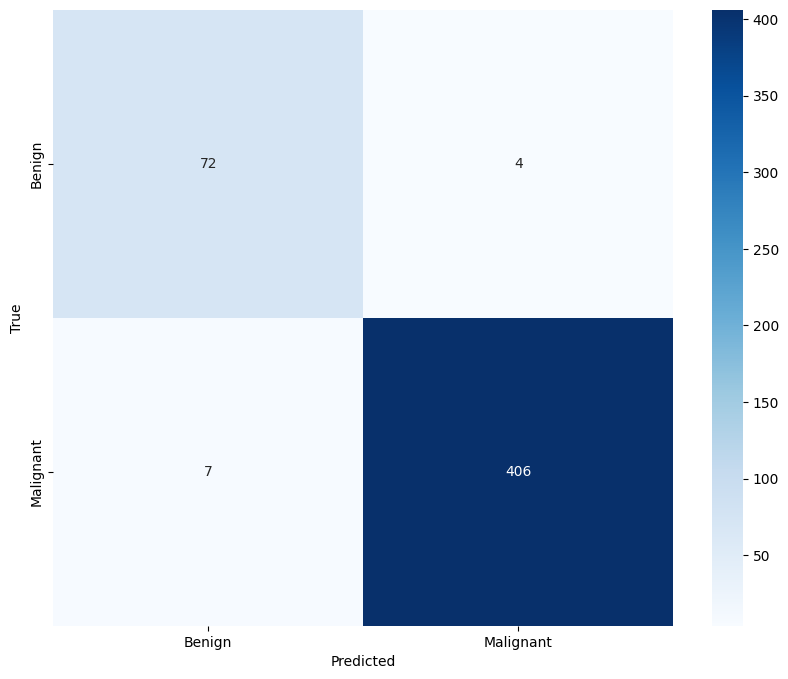

In [7]:
# Evaluate on Test Data
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(target.cpu().numpy())

# Compute Metrics
accuracy = accuracy_score(test_targets, test_preds)
precision = precision_score(test_targets, test_preds, average='weighted')
recall = recall_score(test_targets, test_preds, average='weighted')
f1 = f1_score(test_targets, test_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix and Classification Report
conf_mat = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=train_dataset.classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()